In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys

import momepy
import networkx as nx
from libpysal import weights

%matplotlib inline
import matplotlib.pyplot as plt

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)
import KeyFunctions as kf

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
#Open a small set of geodata to play with
gdf = kf.load_obj(root_path,"raw_gdf_StPauls")

In [3]:
#Extract the all of the roads, and just the A-Roads
Road = gdf.loc[gdf["Type"]=="Road",:].reset_index(drop=True)
A_Road = Road.loc[Road["Name"]=='A Road',:].reset_index(drop=True)

In [4]:
#Create a new variable which is just hte length of the road
A_Road["Length"] = A_Road.geometry.length
A_Road.head()

,Type,Name,Details_Str,Details_Float,geometry,Length
0,Road,A Road,A13,NaN,"LINESTRING Z (534373.000 181318.000 0.000, 534...",43.000000
1,Road,A Road,A13,NaN,"LINESTRING Z (534416.000 181318.000 0.000, 534...",4.000000
2,Road,A Road,A13,NaN,"LINESTRING Z (534420.000 181318.000 0.000, 534...",84.260727
3,Road,A Road,A13,NaN,"LINESTRING Z (534504.250 181318.850 0.000, 534...",45.787390
4,Road,A Road,A13,NaN,"LINESTRING Z (534550.000 181317.000 0.000, 534...",2.001091


In [5]:
#Function to change all multilinestrings into linestrings
def remove_multipart(in_gdf):
    gdf_a = in_gdf[in_gdf.geom_type == 'LineString']
    gdf_b = in_gdf[in_gdf.geom_type == 'MultiLineString']

    gdf_b = gdf_b.explode()

    gdf = gdf_a.append(gdf_b)
    return gdf

In [6]:
#Convert the geodata frame data for a roads into a networkx graph
G = momepy.gdf_to_nx(remove_multipart(A_Road), approach="primal", length="Length")

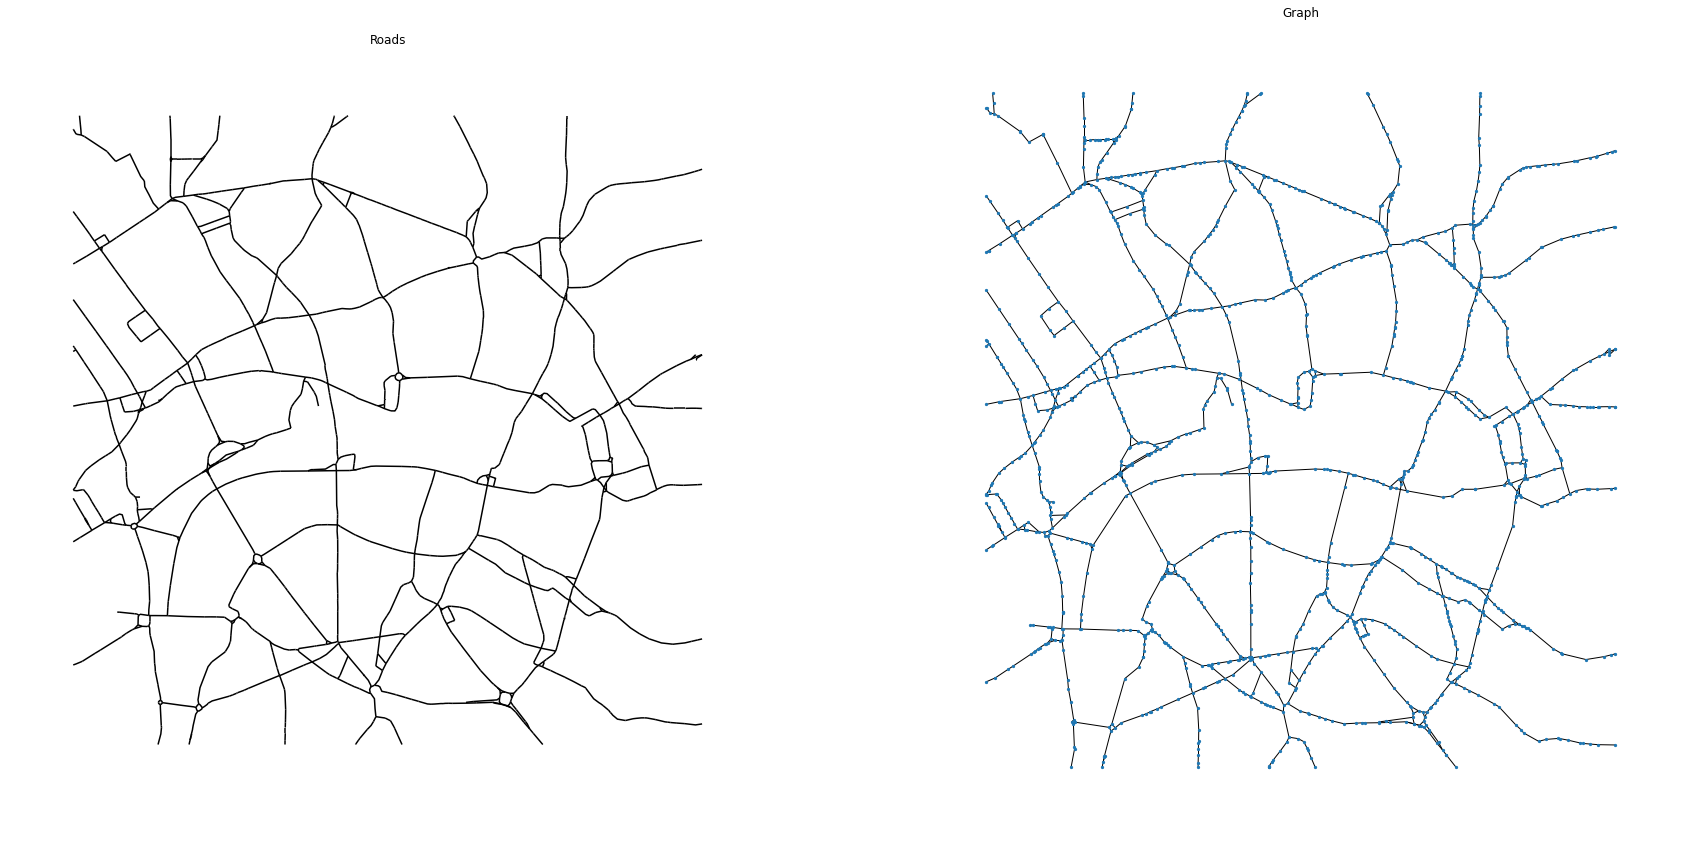

In [8]:
#Plot two versions of the same data. the first being a plot of the linestrings the second being a plot of the nodes and verticies of the roads
    # noice that there are still nodes for junctions for all roads, not just a-road junctions.
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)
A_Road.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Roads", "Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)

In [9]:
#Remove the nodes where there isn't a junction with another A road.
G2 = G.copy()

# 1) get two edges going into that node
# 2) get the lengths of this node
# 3) get the end points that aren't the node
# 4) make a new edge with these details
# 5) drop the old node

for node in list(G2.nodes()):
    if G2.degree(node) == 2:
        # 1) get two edges going into that node
        ed = list(G2.edges(node))

        # 2) get the lengths of this node
        length_1 = list(G2.edges(node,data=True))[0][2]['Length']
        length_2 = list(G2.edges(node,data=True))[1][2]['Length']

        # 3) get the end points that aren't the node
        if ed[0][0]==node:
            start = ed[0][1]
        else:
            start = ed[0][0]

        if ed[1][0]==node:
            end = ed[1][1]
        else:
            end = ed[1][0]

        G2.add_edge(start, end, Length=length_1+length_2)
        G2.remove_node(node)

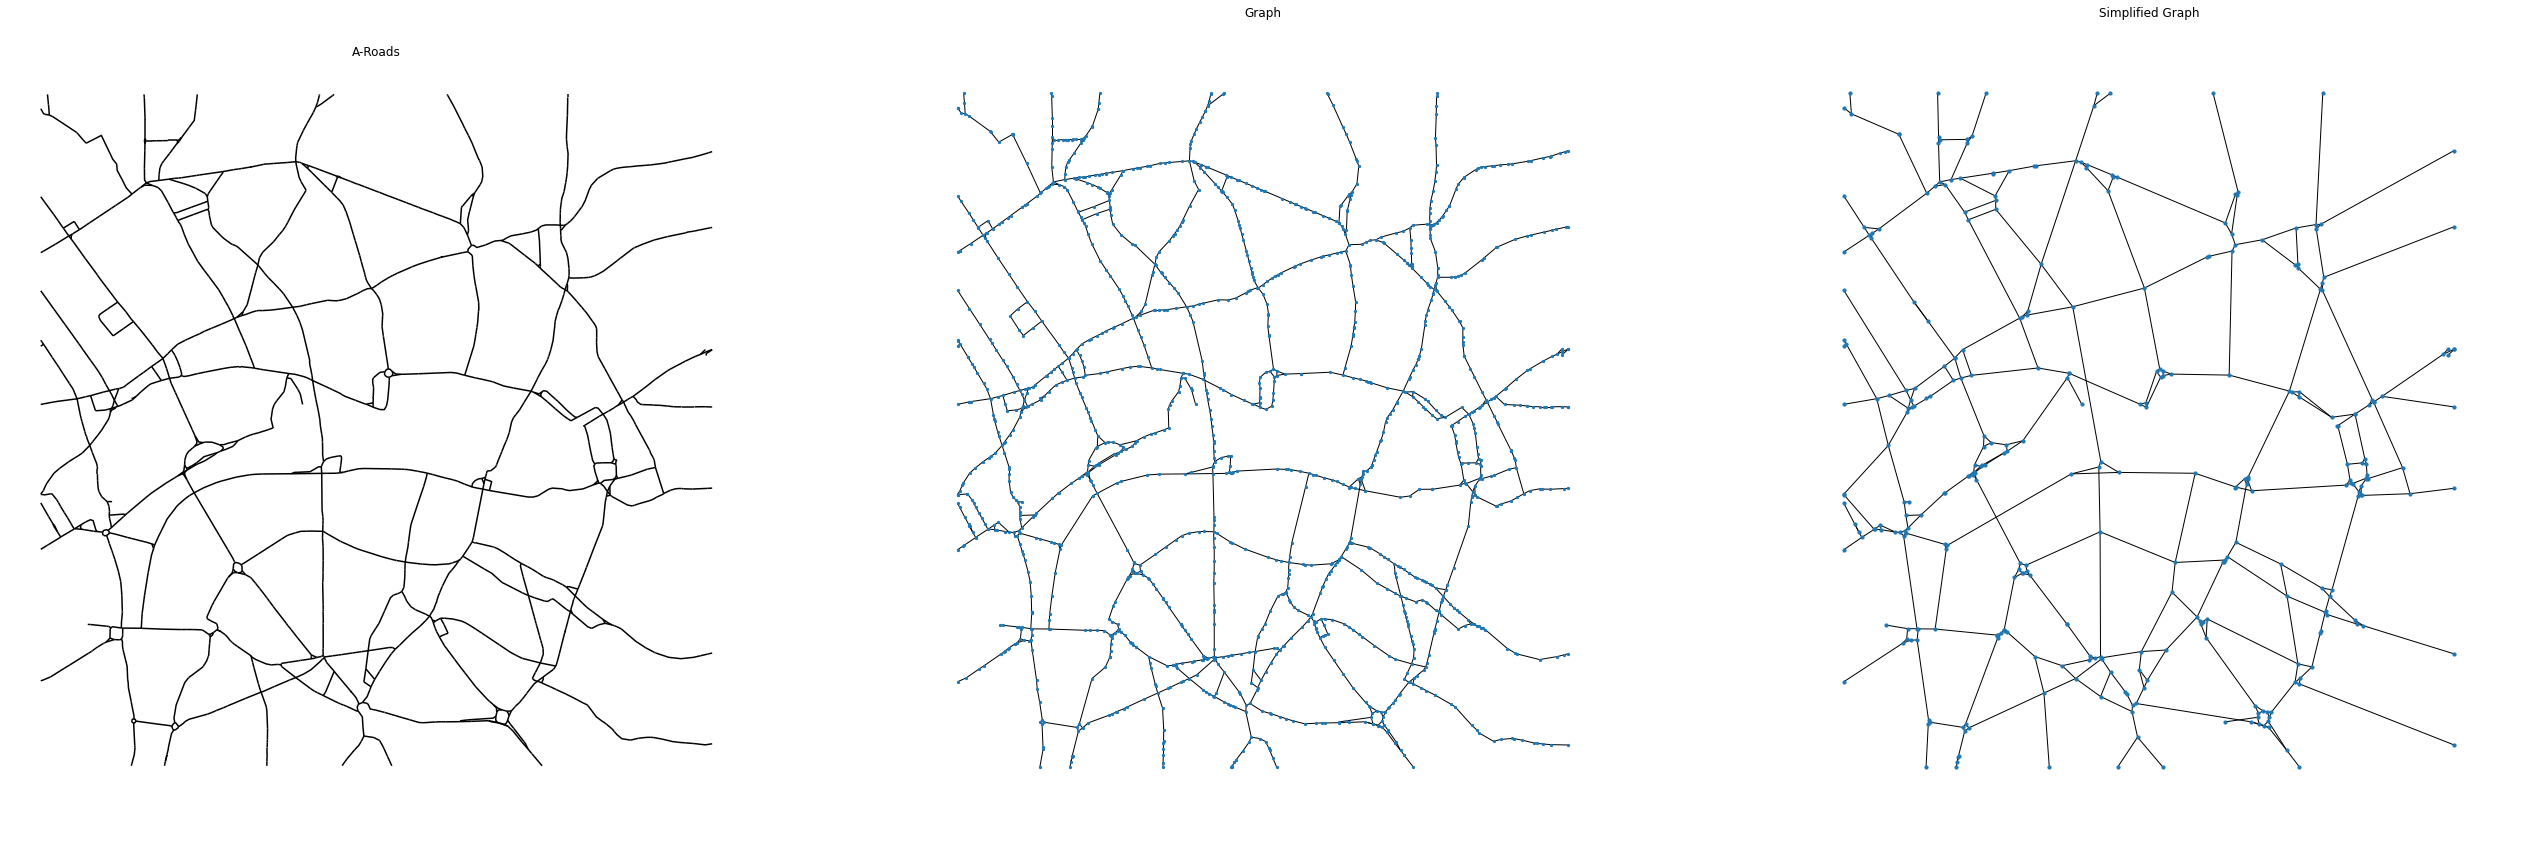

In [10]:
#Plot the three versions of the map. The new map is a much simplified version of the map, but is now less geographically accurate
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 3, figsize=(45, 15))
A_Road.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("A-Roads", "Graph", "Simplified Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)
nx.draw(G2, positions, ax=ax[2], node_size=10)

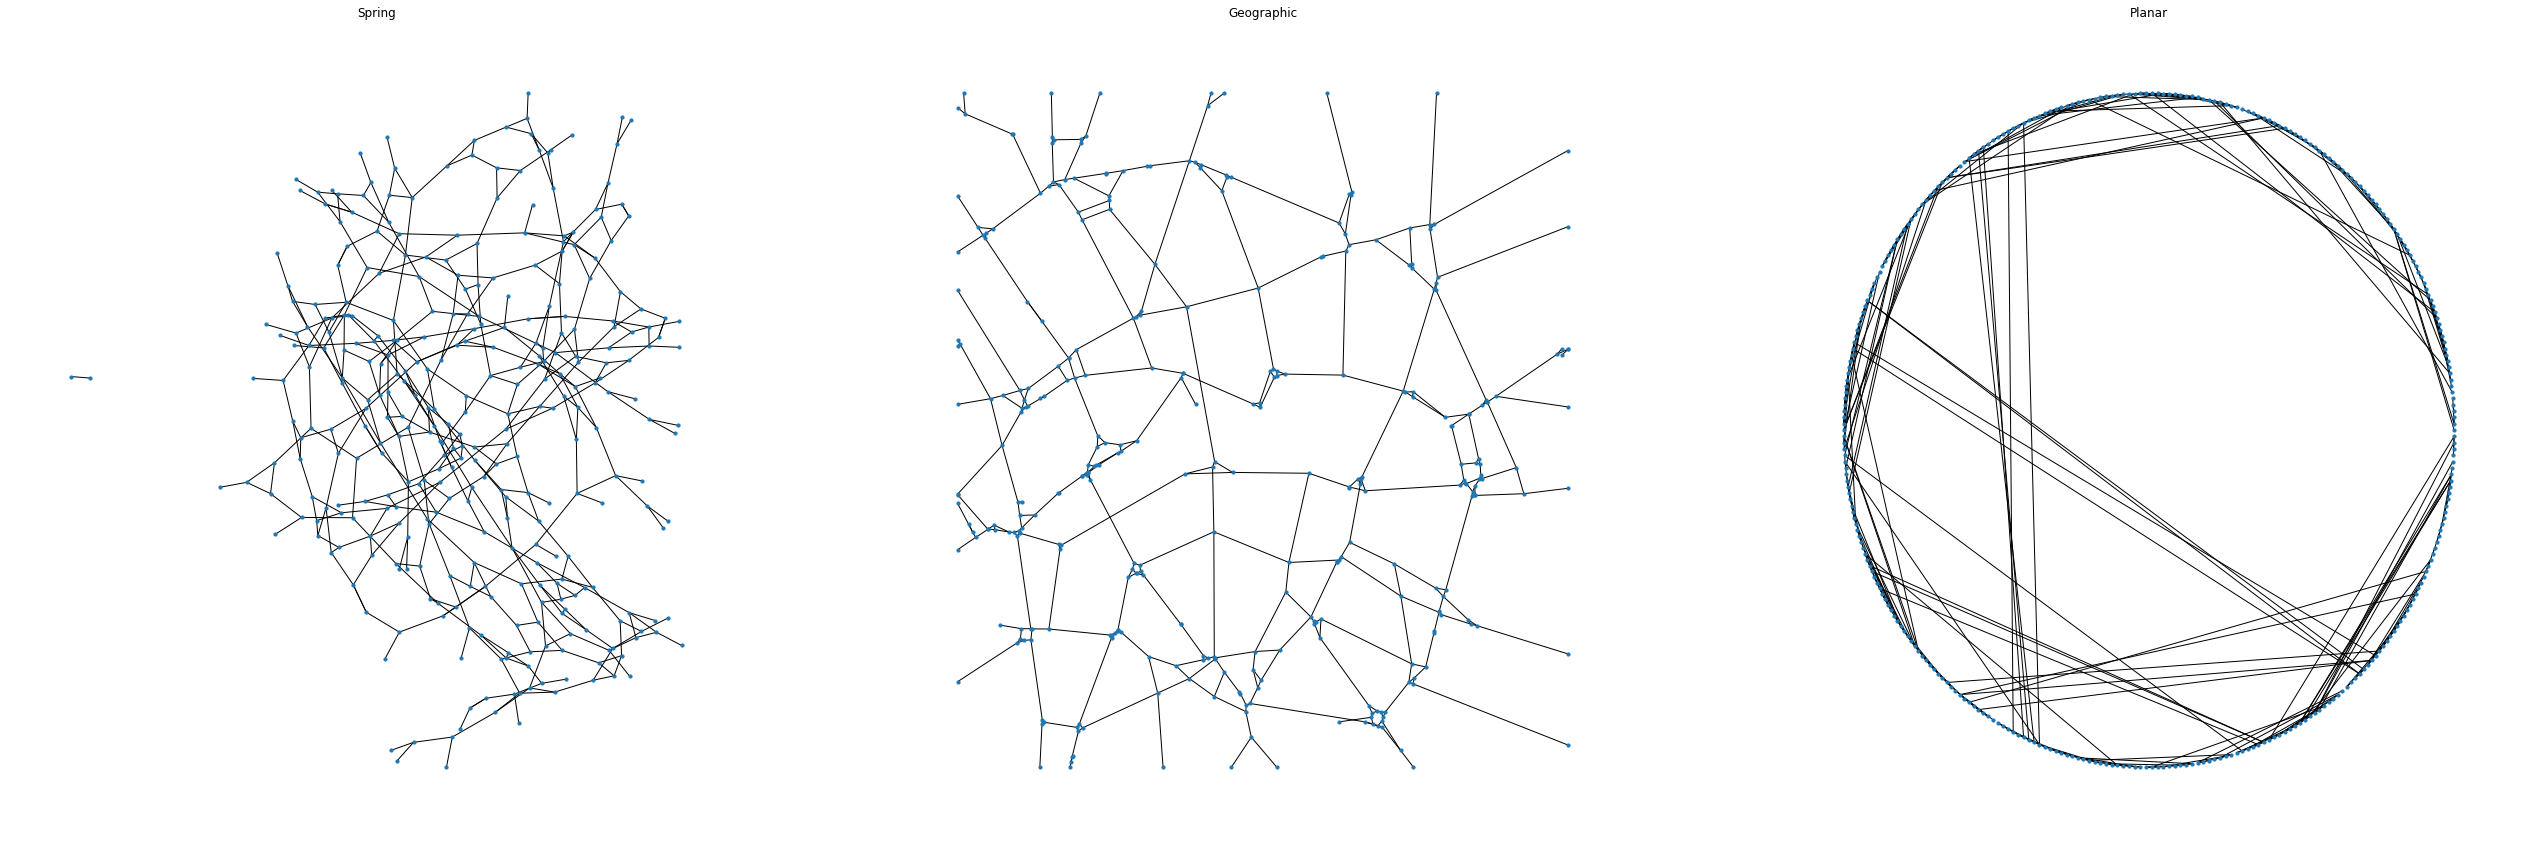

In [11]:
positions = {n: [n[0], n[1]] for n in list(G2.nodes)}

f, ax = plt.subplots(1,3, figsize=(45, 15))
for i, facet in enumerate(ax):
    facet.set_title(("Spring", "Geographic", "Planar")[i])
    facet.axis("off")
nx.draw_spring(G2, ax=ax[0], node_size=10)
nx.draw(G2, positions, ax=ax[1], node_size=10)
nx.draw_circular(G2, ax=ax[2], node_size=10)

In [12]:
G2.number_of_nodes()

334

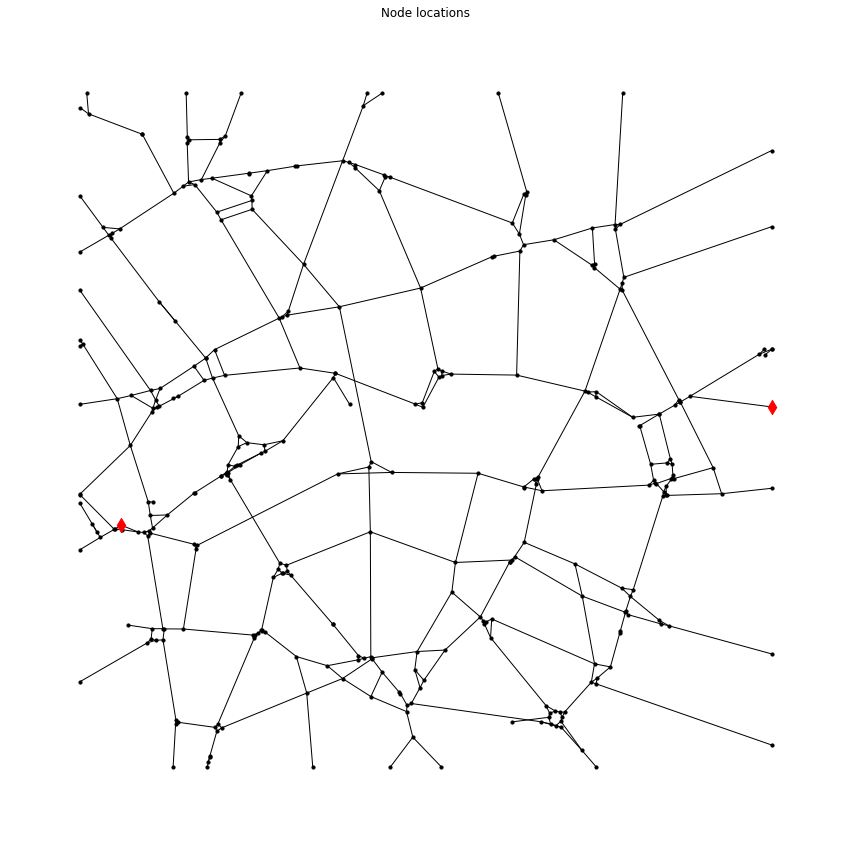

In [13]:
positions = {n: [n[0], n[1]] for n in list(G2.nodes)}

start_node = (534552.0, 181316.93393393393, 0.0)
end_node = (529851.0, 180440.0, 0.0)

f, ax = plt.subplots(1, figsize=(15, 15))
ax.set_title("Node locations")
nx.draw(G2,positions,node_color='k', node_size=10)
nx.draw_networkx_nodes(G2,positions, nodelist=[start_node, end_node], node_color='r', node_size=100, node_shape='d')

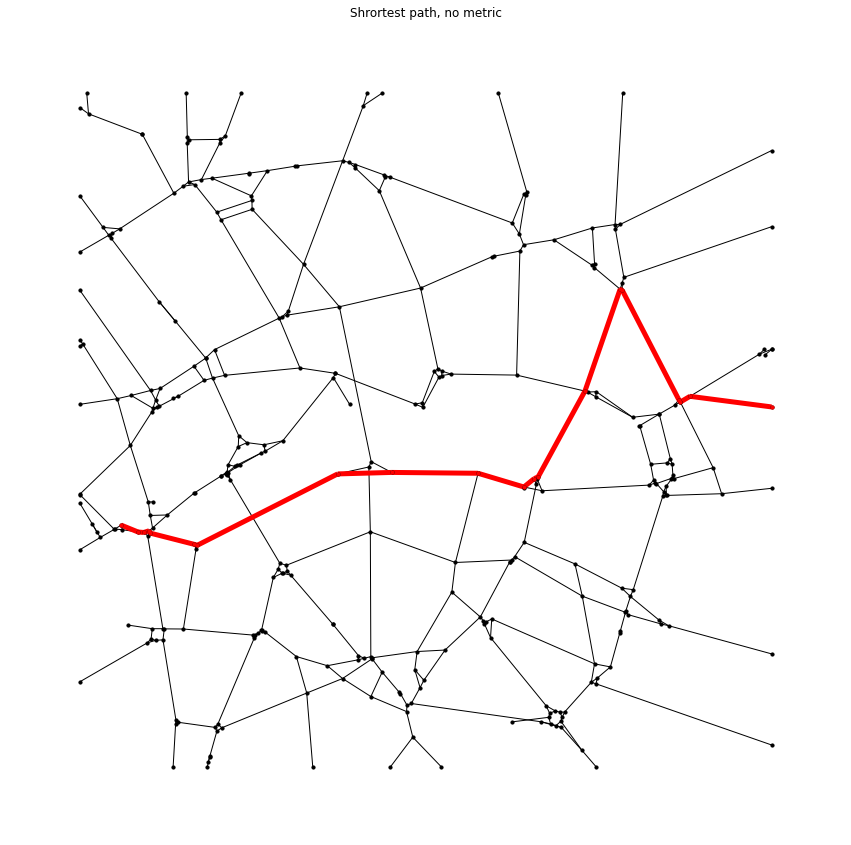

In [19]:
positions = {n: [n[0], n[1]] for n in list(G2.nodes)}

start_node = (534552.0, 181316.93393393393, 0.0)
end_node = (529851.0, 180440.0, 0.0)

shortest_path_nodes = nx.shortest_path(G2, source=start_node, target=end_node)
shortest_path_edges = list(zip(shortest_path_nodes,shortest_path_nodes[1:]))

f, ax = plt.subplots(1, figsize=(15, 15))

ax.set_title("Shrortest path, no metric")
nx.draw(G2,positions,node_color='k', node_size=10)

nx.draw_networkx_nodes(G2,positions, nodelist=shortest_path_nodes, node_color='r', node_size=10)
nx.draw_networkx_edges(G2,positions,edgelist=shortest_path_edges,edge_color='r',width=5)

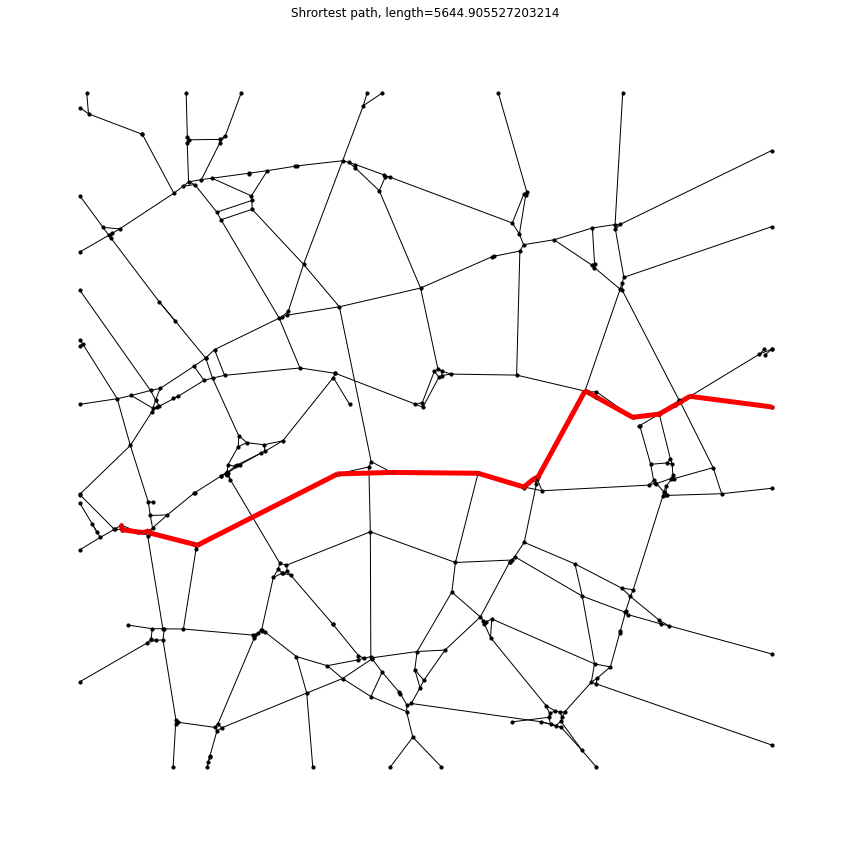

In [22]:
positions = {n: [n[0], n[1]] for n in list(G2.nodes)}

start_node = (534552.0, 181316.93393393393, 0.0)
end_node = (529851.0, 180440.0, 0.0)

shortest_path_nodes = nx.shortest_path(G2, weight='Length', source=start_node, target=end_node)
shortest_path_edges = list(zip(shortest_path_nodes,shortest_path_nodes[1:]))
shortest_length = nx.shortest_path_length(G2, weight='Length', source=start_node, target=end_node)

f, ax = plt.subplots(1, figsize=(15, 15))

ax.set_title("Shrortest path, length="+str(shortest_length))
nx.draw(G2,positions,node_color='k', node_size=10)

nx.draw_networkx_nodes(G2,positions, nodelist=shortest_path_nodes, node_color='r', node_size=10)
nx.draw_networkx_edges(G2,positions,edgelist=shortest_path_edges,edge_color='r',width=5)

#add in the length of this path

In [16]:
#Now lets play with some polygons

In [134]:
LSOA = gdf.loc[gdf["Type"]=="LSOA",:].reset_index(drop=True)
All_GB = gdf.loc[gdf["Type"]=="All_GB",:].reset_index(drop=True)

#Attempt methods from these places
* https://geographicdata.science/book/intro.html 
    * https://geographicdata.science/book/notebooks/04_spatial_weights.html
* https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html

In [135]:
centroids = np.column_stack((LSOA.centroid.x, LSOA.centroid.y))
queen = weights.Queen.from_dataframe(LSOA)
G = queen.to_networkx()
positions = dict(zip(G.nodes, centroids))

AttributeError: 'tuple' object has no attribute 'Queen'

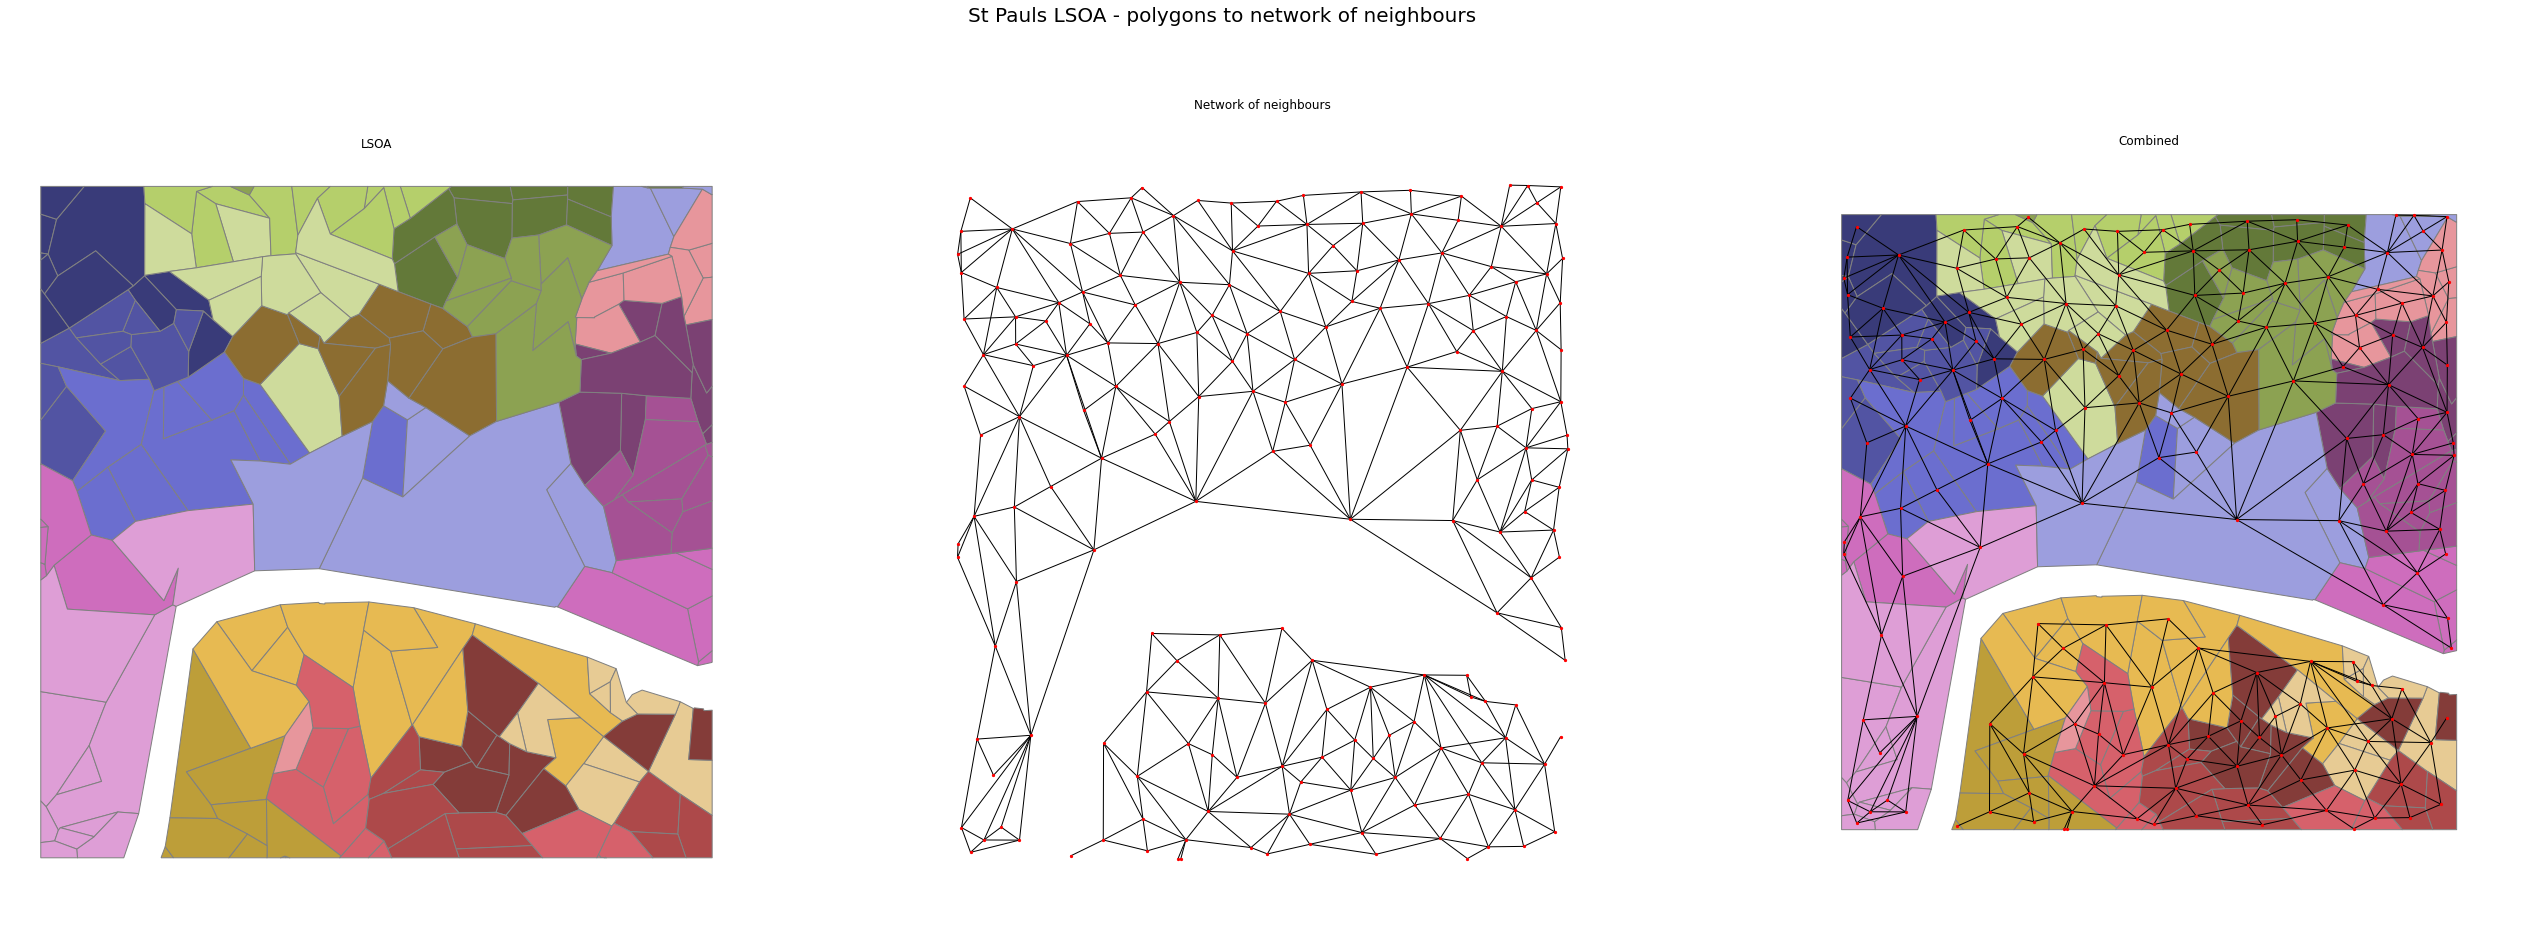

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(45, 15))
fig.suptitle("St Pauls LSOA - polygons to network of neighbours", fontsize=20)

for i, facet in enumerate(ax):
    facet.set_title(("LSOA", "Network of neighbours", "Combined")[i])
    facet.axis("off")

#Plot1 - just the LSOA
LSOA.plot(ax=ax[0], edgecolor='grey', linewidth=1, column="Name", cmap='tab20b',
                                categorical=True, legend=False)

#Plot2 - just the network
nx.draw(G, positions, ax=ax[1], node_size=5, node_color="r")

#Plot 3 - combined network and graph
LSOA.plot(ax=ax[2], edgecolor='grey', linewidth=1, column="Name", cmap='tab20b',
                                categorical=True, legend=False)

nx.draw(G, positions, ax=ax[2], node_size=5, node_color="r")
plt.show()

In [137]:
LSOA["Centroid"] = centroids.tolist()

In [138]:
note_attrib = LSOA.loc[:,["Name","Centroid"]].to_dict('index')
nx.set_node_attributes(G, note_attrib)

In [139]:
def dist_node(n1, n2):
    dist = np.sqrt( (n1["Centroid"][0] - n2["Centroid"][0])**2  + (n1["Centroid"][1] - n2["Centroid"][1])**2 )
    return dist

In [140]:
dist = [dist_node(G.nodes[e[0]], G.nodes[e[1]]) for e in G.edges()]
e_attrib = pd.DataFrame(dist, columns =['Length'])
e_attrib["e"] = G.edges()
e_attrib = e_attrib.set_index("e").to_dict("index")

In [141]:
nx.set_edge_attributes(G,e_attrib)

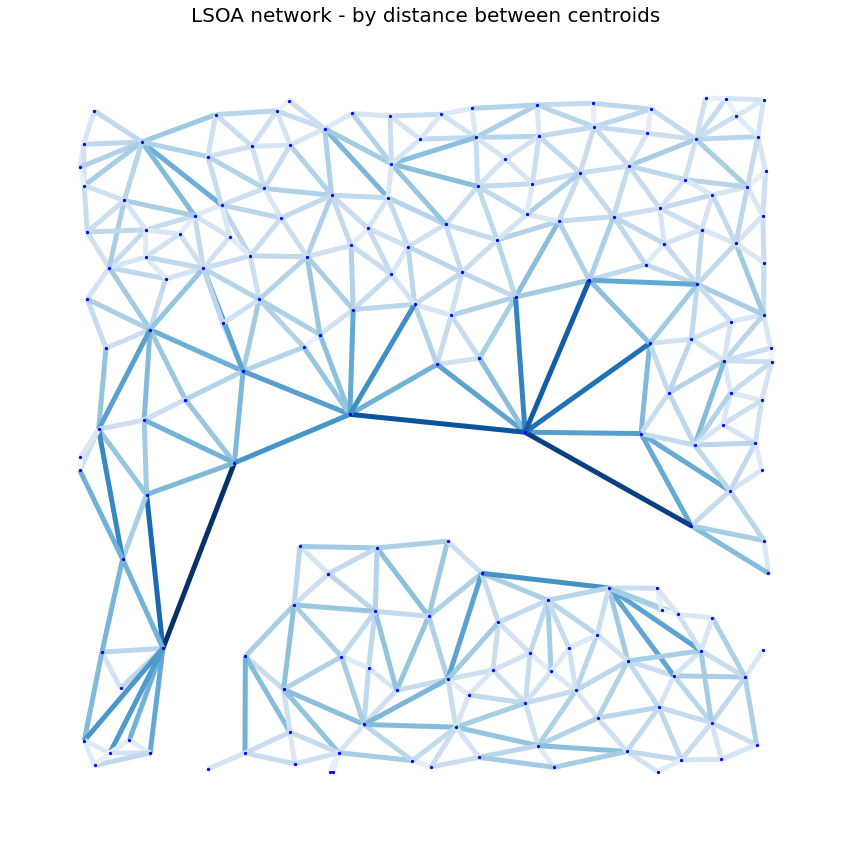

In [142]:
edges,weights = zip(*nx.get_edge_attributes(G,'Length').items())

pos = dict(zip(G.nodes, centroids))

fig, ax = plt.subplots(1, figsize=(15, 15))
ax.set_title("LSOA network - by distance between centroids", size=20)
nx.draw(G, pos, node_color='b', node_size=5, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues, ax=ax)
plt.show()

In [143]:
G.nodes[1]

{'Type': 'LSOA',
 'Centroid': [532436.1157332506, 181714.8752029019],
 'Name': 'City of London 001B'}

In [156]:
G1 = nx.ego_graph(G, 0, 1)
pos_G1 = nx.spring_layout(G1)

G2 = nx.ego_graph(G, 0, 2)
pos_G2 = nx.spring_layout(G2)

G3 = nx.ego_graph(G, 0, 3)
pos_G3 = nx.spring_layout(G3)

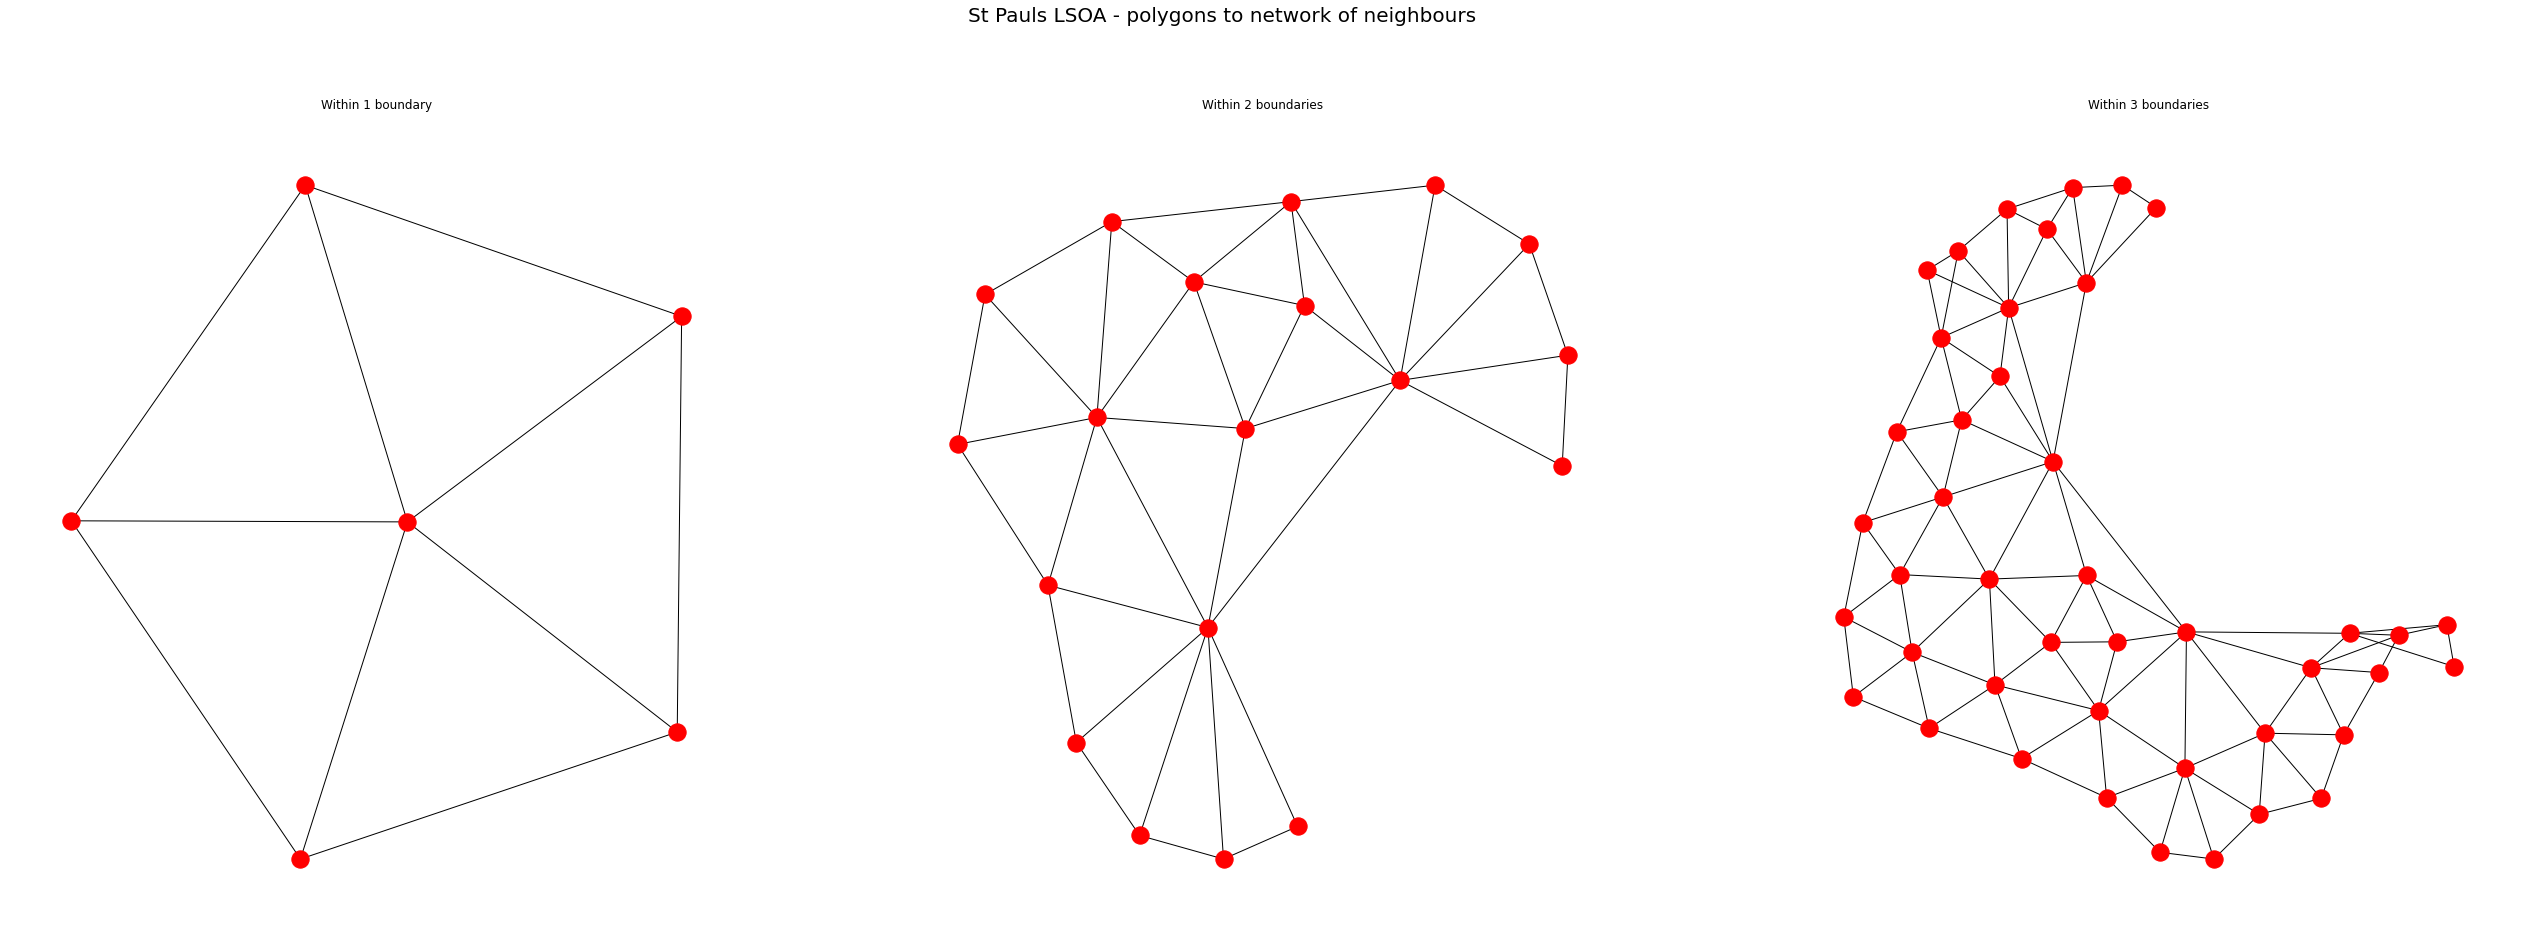

In [160]:
fig, ax = plt.subplots(1, 3, figsize=(45, 15))
fig.suptitle("St Pauls LSOA - polygons to network of neighbours", fontsize=20)

for i, facet in enumerate(ax):
    facet.set_title(("Within 1 boundary", "Within 2 boundaries", "Within 3 boundaries")[i])
    facet.axis("off")

#Plot1

nx.draw(G1, pos_G1, ax=ax[0], node_color="r")

#Plot2
nx.draw(G2, pos_G2, ax=ax[1], node_color="r")

#Plot3
nx.draw(G3, pos_G3, ax=ax[2], node_color="r")


plt.show()